In [27]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from bayes_traj.pyro_helper import *

torch.set_default_dtype(torch.double)

# Read toy data and plot

In [2]:
df = pd.read_csv('4d_binary_20_visits.csv')
preds = ['intercept', 'x', 'x^2', 'x^3']
targets = ['y1']

Color-code data based on ground-truth trajectory assignment ('traj_gt')

Text(0, 0.5, 'y1')

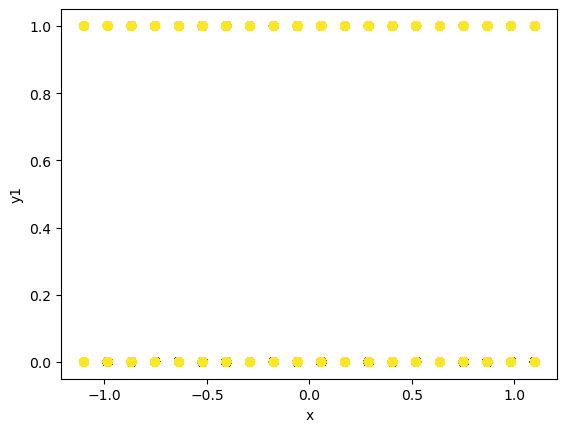

In [3]:
plt.scatter(df['x'], df['y1'], c=df['traj_gt'])
plt.xlabel('x')
plt.ylabel('y1')

# Fit to data

In [28]:
!bayes_traj_main --in_csv 4d_binary_20_visits.csv --targets y1 --groupby id --prior 4d_binary_20_visits_prior.p --verbose --iters 1000 --repeats 1 --use_pyro -k 3 --out_model foo_pyro.pt

Reading prior...
Reading data...
Fitting...
step    0 loss = 0.373
step  100 loss = 0.350
step  200 loss = 0.350
step  300 loss = 0.349
step  400 loss = 0.349
step  500 loss = 0.349
step  600 loss = 0.348
step  700 loss = 0.349
step  800 loss = 0.349
step  900 loss = 0.349
DONE.


# Inspect fit

In [29]:
model = torch.load('foo_pyro.pt')

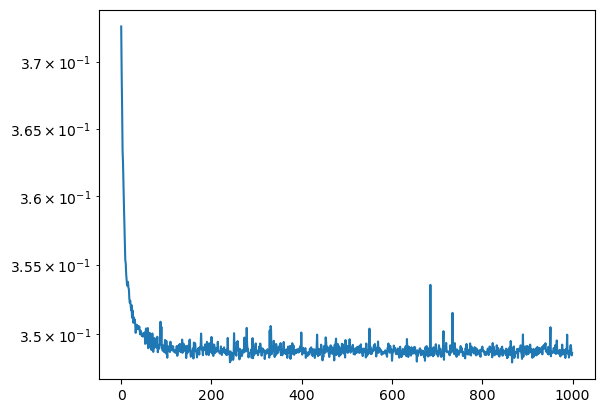

In [30]:
plt.plot(model.losses)
plt.yscale('log')

In [31]:
#X, X_mask, Y_real, Y_real_mask, Y_bool, Y_bool_mask = get_restructured_data(df, preds, targets, 'id')
blah = get_restructured_data(df, preds, targets, 'id')
#print(X.shape)
#print(Y_real.shape)
#print(Y_bool.shape)
len(blah)

4

In [8]:
probs = model.classify(X_re, Y_real=Y_re, Y_real_mask=Y_mask)

In [11]:
print(np.sum(probs.numpy(), 0))

[400.   0.   0.]


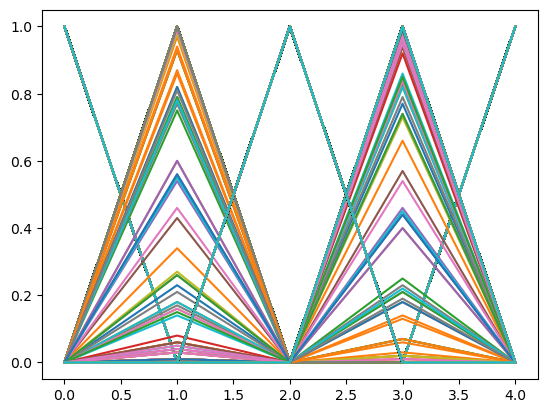

In [14]:
plt.plot(probs.T);

Overlap trajectories with data to inspect fit:

In [24]:
np.sum(probs.numpy(),0)

array([600.  , 621.26, 600.  , 578.74, 600.  ])

In [22]:
np.argmax(probs.numpy(), axis=1)

array([4, 4, 4, ..., 2, 2, 2])

In [23]:
df['traj_gt']

0       1
1       1
2       1
3       1
4       1
       ..
8995    5
8996    5
8997    5
8998    5
8999    5
Name: traj_gt, Length: 9000, dtype: int64

ValueError: 'c' argument has 3000 elements, which is inconsistent with 'x' and 'y' with size 9000.

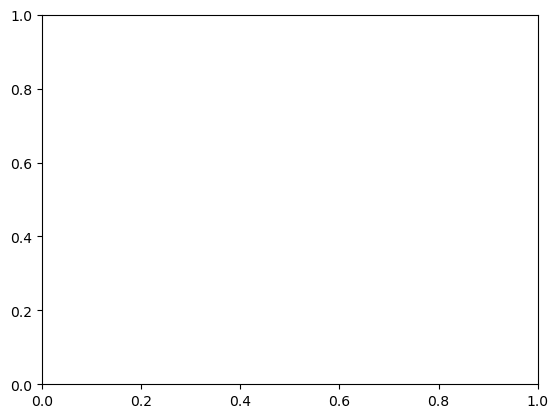

In [21]:
plt.close('all')


#plt.scatter(df['age'], df['y1'], c=df['traj_gt'])
plt.scatter(df['age'], df['y1'], c=np.argmax(probs.numpy(), axis=1))
plt.xlabel('age')
plt.ylabel('y1')

K = 5
X = torch.ones([100, 2])
X[:, 1] = torch.linspace(45, 90, 100)
for kk in range(K):
    w = model.params['params']['AutoNormal.locs.W_'][kk, 0].data.numpy()
    lambda_ = model.params['params']['AutoNormal.locs.lambda_'][kk].data
    stddev = lambda_.rsqrt().numpy()
    y1_tmp = np.dot(X.numpy(), w.T)
    plt.plot(X[:, 1], y1_tmp)
    lb = y1_tmp - 2*stddev
    ub = y1_tmp + 2*stddev
    plt.fill_between(X[:, 1], lb, ub, alpha=0.2)
plt.show()

In [ ]:
q